In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
yield_data = pd.read_csv("data/yield.csv")


# Convert to datetime and set as index
yield_data['Date'] = pd.to_datetime(yield_data['Date'])
yield_data.set_index('Date', inplace=True)

# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
yield_data_drop = yield_data.drop(columns=columns_to_drop)

# Rename columns
column_rename_mapping = {
    'BETA0': 'LongTermRate',    # Reflects investor confidence about long-term economic growth and inflation
    'BETA1': 'Slope',           # A negative slope (yield curve inversion) signals a possible recession
}


# https://www.federalreserve.gov/pubs/feds/2006/200628/200628pap.pdf   <=== labels for the columns plus info on data
for i in range(1, 30):
    column_rename_mapping[f'SVENY{i:02d}'] = f'ZeroCouponYield{i}Y'
    column_rename_mapping[f'SVENF{i:02d}'] = f'InstantaneousForwardRate{i}Y'
    yield_data = yield_data.drop(columns=f'SVENPY{i:02d}')
yield_data.rename(columns=column_rename_mapping, inplace=True)


# Resample to monthly frequency (convert from 'B' to 'M')
yield_data = yield_data.resample('M').mean()

# Interpolate missing values 
yield_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)


columns_of_interest = ['Slope', 'LongTermRate'] + \
                      [f'ZeroCouponYield{i}Y' for i in range(1, 11)] + \
                      [f'InstantaneousForwardRate{i}Y' for i in range(1, 11)]


new_yield_data = yield_data[columns_of_interest]


new_yield_data.head()



C:\Users\devpa\AppData\Local\Temp\ipykernel_95676\2704976327.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  yield_data = yield_data.resample('M').mean()
C:\Users\devpa\AppData\Local\Temp\ipykernel_95676\2704976327.py:35: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  yield_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)


,Slope,LongTermRate,ZeroCouponYield1Y,ZeroCouponYield2Y,ZeroCouponYield3Y,ZeroCouponYield4Y,ZeroCouponYield5Y,ZeroCouponYield6Y,ZeroCouponYield7Y,ZeroCouponYield8Y,...,InstantaneousForwardRate1Y,InstantaneousForwardRate2Y,InstantaneousForwardRate3Y,InstantaneousForwardRate4Y,InstantaneousForwardRate5Y,InstantaneousForwardRate6Y,InstantaneousForwardRate7Y,InstantaneousForwardRate8Y,InstantaneousForwardRate9Y,InstantaneousForwardRate10Y
Date,,,,,,,,,,,,,,,,,,,,,
1961-06-30,-1.268221,4.002757,2.974685,3.383562,3.580031,3.684631,3.748146,3.790554,3.820877,NaN,...,3.533592,3.934585,3.993169,4.001369,4.002562,4.002731,4.002762,NaN,NaN,NaN
1961-07-31,-1.967420,4.100839,2.841955,3.289770,3.531040,3.668470,3.754025,3.811640,3.852910,NaN,...,3.436640,3.934995,4.062475,4.092050,4.098790,4.100355,4.100720,NaN,NaN,NaN
1961-08-31,-1.712356,4.248369,3.001652,3.420465,3.661852,3.802339,3.890426,3.949861,3.992443,NaN,...,3.522839,4.054435,4.201822,4.237530,4.245861,4.247778,4.248226,NaN,NaN,NaN
1961-09-30,-1.691689,4.130283,3.043195,3.445030,3.654595,3.770960,3.842475,3.890400,3.924650,NaN,...,3.581385,4.014040,4.108765,4.126550,4.129645,4.130185,4.130270,NaN,NaN,NaN
1961-10-31,-1.607382,3.815504,2.962929,3.350962,3.559624,3.674895,3.739548,3.776095,3.796800,NaN,...,3.489457,3.907943,4.016624,4.014843,3.979167,3.938957,3.904257,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Load the dataset
file_path = 'processed_yield_data.csv'  # Adjust path as needed
yield_data = new_yield_data

# Relevant columns for predictors (adjust names as necessary)
predictors = ['ZeroCouponYield1Y', 'ZeroCouponYield2Y', 'ZeroCouponYield3Y',
              'ZeroCouponYield4Y', 'ZeroCouponYield5Y', 'ZeroCouponYield6Y',
              'ZeroCouponYield7Y']
target = 'ZeroCouponYield10Y'

# Flip the dataset for easier iterative prediction
flipped_data = yield_data.iloc[::-1].reset_index(drop=True)

# Prepare lag features for predictors and target
lagged_data = flipped_data.copy()
for col in predictors + [target]:
    for lag in range(1, 4):  # Using lag 1 to 3
        lagged_data[f"{col}_lag{lag}"] = lagged_data[col].shift(lag)

# Drop rows with missing lagged values
lagged_data = lagged_data.dropna()

# Split into features and target
feature_columns = [f"{col}_lag{lag}" for col in predictors for lag in range(1, 4)]
X = lagged_data[feature_columns]
y = lagged_data[target]

# Train-test split for validation (optional)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)



In [ ]:
# Predict missing values for ZeroCouponYield10Y
for idx in flipped_data.index:
    if pd.isna(flipped_data.loc[idx, target]):
        # Gather lagged predictor values
        row_features = []
        for col in predictors:
            for lag in range(1, 4):
                lag_idx = idx + lag
                if lag_idx >= len(flipped_data) or pd.isna(flipped_data.loc[lag_idx, col]):
                    row_features = None
                    break
                row_features.append(flipped_data.loc[lag_idx, col])
            if row_features is None:
                break
        
        if row_features is not None:
            # Predict missing value
            prediction = model.predict(np.array(row_features).reshape(1, -1))
            flipped_data.loc[idx, target] = prediction[0]

# Reverse back to original order and update the dataset
filled_data = flipped_data.iloc[::-1].reset_index(drop=True)
yield_data[target + '_filled'] = filled_data[target]

# Save the updated dataset
updated_file_path = 'processed_yield_data_filled_multivariate.csv'  # Adjust path if needed
yield_data.to_csv(updated_file_path, index=False)

print(f"Updated dataset saved to {updated_file_path}")


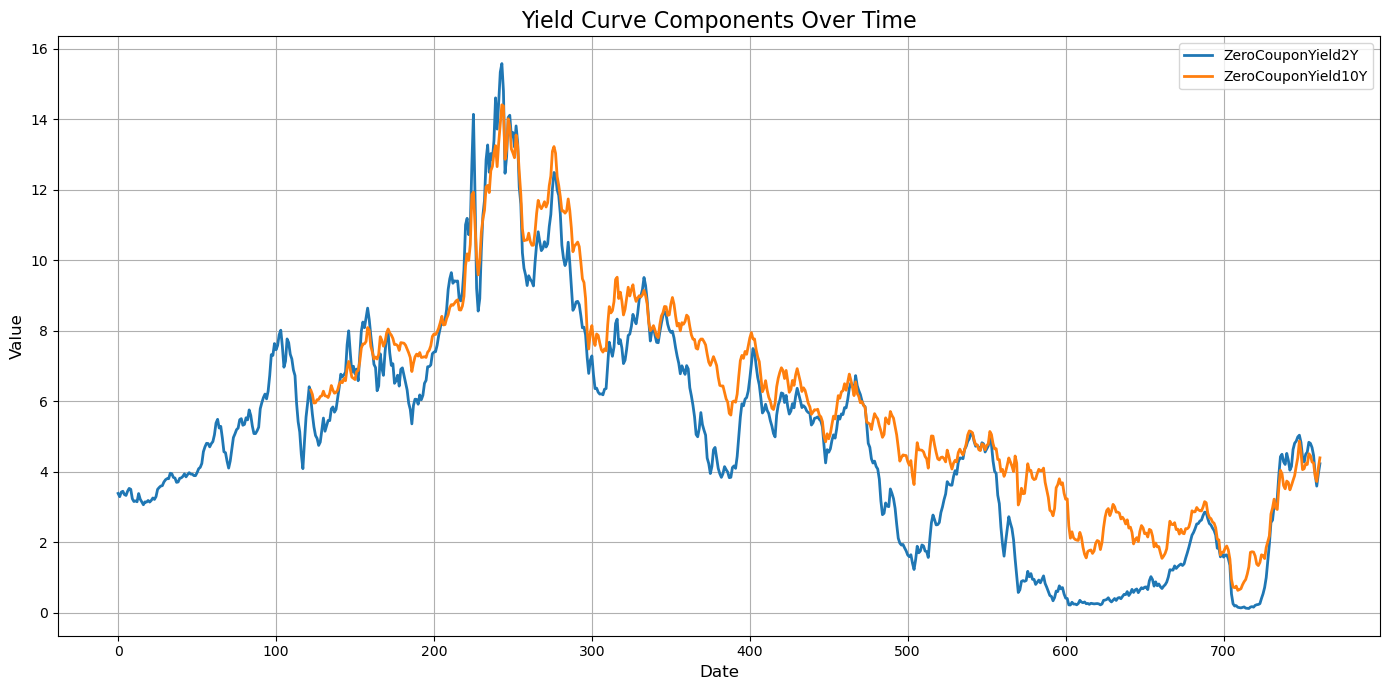

In [7]:
# Plot: Line plot for LongTermRate and Slope
plt.figure(figsize=(14, 7))
plt.plot(yield_data.index, yield_data['ZeroCouponYield2Y'], label='ZeroCouponYield2Y', linewidth=2)
plt.plot(yield_data.index, yield_data['ZeroCouponYield10Y'], label='ZeroCouponYield10Y', linewidth=2)

# Add labels, legend, and title
plt.title('Yield Curve Components Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [11]:

yield_data = pd.read_csv('processed_yield_data.csv')

# Display the first few rows of the dataset to understand its structure
yield_data.head()


,Date,LongTermRate,Slope,ZeroCouponYield2Y,ZeroCouponYield10Y,InstantaneousForwardRate2Y,InstantaneousForwardRate10Y,Normalized_LongTermRate,Normalized_Slope,Normalized_ZeroCouponYield2Y,Normalized_ZeroCouponYield10Y,Normalized_InstantaneousForwardRate2Y,Normalized_InstantaneousForwardRate10Y
0,1961-06-30,4.002757,-1.268221,3.383562,NaN,3.934585,NaN,0.160110,0.463769,0.211179,NaN,0.255323,NaN
1,1961-07-31,4.100839,-1.967420,3.289770,NaN,3.934995,NaN,0.164034,0.446137,0.205111,NaN,0.255350,NaN
2,1961-08-31,4.248369,-1.712356,3.420465,NaN,4.054435,NaN,0.169935,0.452569,0.213567,NaN,0.263449,NaN
3,1961-09-30,4.130283,-1.691689,3.445030,NaN,4.014040,NaN,0.165211,0.453090,0.215156,NaN,0.260710,NaN
4,1961-10-31,3.815504,-1.607382,3.350962,NaN,3.907943,NaN,0.152620,0.455216,0.209070,NaN,0.253516,NaN
